In [121]:
import os
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import torch.optim as optim

from PIL import Image, ImageFile 
ImageFile.LOAD_TRUNCATED_IMAGES = True

import albumentations as A 
from albumentations.pytorch import ToTensorV2 

import pandas as pd 

import matplotlib.patches as patches 

from tqdm import tqdm


In [122]:
# Divide the annotation file into multiple .txt files for each image
# Define the paths
annotation_path = "/home/andrew42/Downloads/CV_project/ComputerVision-main/grocery_annotations/annotation.txt"
image_dir = "/home/andrew42/Downloads/CV_project/ComputerVision-main/Images_Grocery/ShelfImages"

# Open the annotation file
with open(annotation_path, 'r') as f:
    lines = f.readlines()

# Process each line
for line in lines:
    parts = line.split()
    image_name = parts[0]
    num_objects = int(parts[1])
    objects = [parts[i:i+5] for i in range(2, len(parts), 5)]

    # Create a new annotation file for this image
    with open(os.path.join(image_dir, image_name + '.txt'), 'w') as f:
        for obj in objects:
            # Write the object annotation to the file
            f.write(' '.join(obj) + '\n')

In [123]:
# Device 
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load and save model variable 
load_model = False
save_model = True

# model checkpoint file name 
checkpoint_file = "checkpoint.pth.tar"

# Anchor boxes for each feature map scaled between 0 and 1 
# 3 feature maps at 3 different scales based on YOLOv3 paper 
ANCHORS = [ 
	[(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)], 
	[(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)], 
	[(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)], 
] 

# Batch size for training 
batch_size = 32

# Learning rate for training 
leanring_rate = 1e-5

# Number of epochs for training 
epochs = 20

# Image size 
image_size = 416

# Grid cell sizes 
s = [image_size // 32, image_size // 16, image_size // 8] 

# Class labels 
class_labels = [ 
	0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11
]


In [124]:
from sklearn.model_selection import train_test_split

def list_files(full_data_path = "/home/andrew42/Downloads/CV_project/ComputerVision-main/Images_Grocery/ShelfImages", image_ext = '.JPG', test_size = 0.15, validation_size = 0.15):

    files = []

    for r, d, f in os.walk(full_data_path):
        for file in f:
            if file.endswith(image_ext):
                files.append(file)

    # Split the data into training and testing
    train_files, test_files = train_test_split(files, test_size=test_size, random_state=42)

    # Split the training data into training and validation
    train_files, val_files = train_test_split(train_files, test_size=validation_size, random_state=42)

    return train_files, val_files, test_files

In [125]:
training_files, validation_files, test_files = list_files()

print(str(len(training_files)) + " training files")
print(str(len(validation_files)) + " validation files")
print(str(len(test_files)) + " test files")

255 training files
45 validation files
54 test files


In [126]:
input_size = 244
new_size = (244, 244)  # New size (height, width)

def resize_image_and_box(img, box):
    # Calculate the scale factors
    y_scale = input_size / img.shape[0]
    x_scale = input_size / img.shape[1]

    # Resize the image
    resized_img = cv2.resize(img, new_size)

    x, y, w, h = box[0], box[1], box[2], box[3]
    #new_box = [int(x / r), int(y / r), int(w / r), int(h / r)]
    
    # Scale the bounding box coordinates
    resized_box = [int(box[0] * x_scale), int(box[1] * y_scale), int(box[2] * x_scale), int(box[3] * y_scale)]

    return resized_img, resized_box

def format_image(img1, box1):
    img = img1.copy()
    box = box1.copy()
    height, width = img.shape
    max_size = max(height, width)
    r = max_size / input_size
    new_width = int(width / r)
    new_height = int(height / r)
    new_size = (new_width, new_height)
    resized = cv2.resize(img, new_size, interpolation= cv2.INTER_AREA)
    new_image = np.zeros((input_size, input_size), dtype=np.uint8)
    new_image[0:new_height, 0:new_width] = resized

    x, y, w, h = box[0], box[1], box[2], box[3]
    new_box = [int(x / r), int(y / r), int(w / r), int(h / r)]
    
    return new_image, new_box

In [127]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, image_dir, anchors, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.anchors = anchors  # Adding anchors as a class attribute
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        entry = self.dataset[idx]

        # If you want to apply any image transformations
        if self.transform:
            entry["image"] = self.transform(entry["image"])

        # Convert to PyTorch tensor
        image = transforms.ToTensor()(entry["image"])

        # Convert bounding boxes and class labels to tensors
        bounding_boxes = torch.tensor(entry["bounding_boxes"], dtype=torch.float32)
        class_labels = torch.tensor(entry["class_label"], dtype=torch.int64)

        # Create target dictionary
        target = {
            'boxes': bounding_boxes,
            'labels': class_labels
        }

        return image, target
    
    def create_dataset(self, files, full_data_path = "/home/andrew42/Downloads/CV_project/ComputerVision-main/Images_Grocery/ShelfImages"):
        dataset = []
        
        for file in files:
            # Load the image in grayscale
            img = cv2.imread(os.path.join(full_data_path, file), cv2.IMREAD_GRAYSCALE)
            k = 1
            labels = []
            with open(os.path.join(full_data_path, file + ".txt"), 'r') as fp:
                lines = fp.readlines()
                boxes = []
                for line in lines:
                    parts = line.split()
                    box = np.array(parts[:4], dtype=float)
                    copy_img, box = format_image(img, box)
                    copy_img = copy_img.astype(float) / 255.
                    boxes.append(box)
                    labels.append(k)
                    
                dataset.append({
                    "image": copy_img,
                    "bounding_boxes": boxes,
                    "class_label": labels
                })

        return dataset


custom_dataset = CustomDataset(training_files)

# Example: Using DataLoader
dataloader = DataLoader(custom_dataset, batch_size=1, shuffle=True, num_workers=0)


TypeError: CustomDataset.__init__() missing 2 required positional arguments: 'image_dir' and 'anchors'

In [ ]:
# Transform for training 
train_transform = A.Compose( 
	[ 
		# Rescale an image so that maximum side is equal to image_size 
		A.LongestMaxSize(max_size=image_size), 
		# Pad remaining areas with zeros 
		A.PadIfNeeded( 
			min_height=image_size, min_width=image_size, border_mode=cv2.BORDER_CONSTANT 
		), 
		# Random color jittering 
		A.ColorJitter( 
			brightness=0.5, contrast=0.5, 
			saturation=0.5, hue=0.5, p=0.5
		), 
		# Flip the image horizontally 
		A.HorizontalFlip(p=0.5), 
		# Normalize the image 
		A.Normalize( 
			mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255
		), 
		# Convert the image to PyTorch tensor 
		ToTensorV2() 
	], 
	# Augmentation for bounding boxes 
	bbox_params=A.BboxParams( 
					format="yolo", 
					min_visibility=0.4, 
					label_fields=[] 
				) 
) 

# Transform for testing 
test_transform = A.Compose( 
	[ 
		# Rescale an image so that maximum side is equal to image_size 
		A.LongestMaxSize(max_size=image_size), 
		# Pad remaining areas with zeros 
		A.PadIfNeeded( 
			min_height=image_size, min_width=image_size, border_mode=cv2.BORDER_CONSTANT 
		), 
		# Normalize the image 
		A.Normalize( 
			mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255
		), 
		# Convert the image to PyTorch tensor 
		ToTensorV2() 
	], 
	# Augmentation for bounding boxes 
	bbox_params=A.BboxParams( 
					format="yolo", 
					min_visibility=0.4, 
					label_fields=[] 
				) 
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


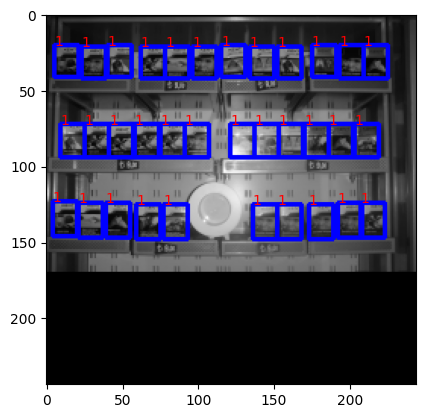

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Get the first batch from the dataloader
first_batch = next(iter(dataloader))

# Get the first image, bounding boxes, and labels from the batch
images = first_batch[0]
targets = first_batch[1]
#class_labels = first_batch['class_label']

# Convert the image tensor to a numpy array and transpose the dimensions for matplotlib
image = images[0].squeeze(0).squeeze(0)

# Convert the image to float32
image = image.numpy().astype(np.float32)

# Convert the grayscale image to RGB
temp_color_img = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

# Get the first bounding box and convert it to numpy
boxes = targets['boxes'][0].numpy()
labels = targets['labels'][0].numpy()
for box, label in zip(boxes, labels):
    x, y, w, h = int(box[0]),int(box[1]), int(box[2]), int(box[3])
    cv2.rectangle(temp_color_img, (x, y), (x+w, y+h), (0, 0, 255), 2)
    plt.text(x, y, str(label), color='red')
plt.imshow(temp_color_img)

In [ ]:
# Defining CNN Block 
class CNNBlock(nn.Module): 
	def __init__(self, in_channels, out_channels, use_batch_norm=True, **kwargs): 
		super().__init__() 
		self.conv = nn.Conv2d(in_channels, out_channels, bias=not use_batch_norm, **kwargs) 
		self.bn = nn.BatchNorm2d(out_channels) 
		self.activation = nn.LeakyReLU(0.1) 
		self.use_batch_norm = use_batch_norm 

	def forward(self, x): 
		# Applying convolution 
		x = self.conv(x) 
		# Applying BatchNorm and activation if needed 
		if self.use_batch_norm: 
			x = self.bn(x) 
			return self.activation(x) 
		else: 
			return x


In [ ]:
# Defining residual block 
class ResidualBlock(nn.Module): 
	def __init__(self, channels, use_residual=True, num_repeats=1): 
		super().__init__() 
		
		# Defining all the layers in a list and adding them based on number of 
		# repeats mentioned in the design 
		res_layers = [] 
		for _ in range(num_repeats): 
			res_layers += [ 
				nn.Sequential( 
					nn.Conv2d(channels, channels // 2, kernel_size=1), 
					nn.BatchNorm2d(channels // 2), 
					nn.LeakyReLU(0.1), 
					nn.Conv2d(channels // 2, channels, kernel_size=3, padding=1), 
					nn.BatchNorm2d(channels), 
					nn.LeakyReLU(0.1) 
				) 
			] 
		self.layers = nn.ModuleList(res_layers) 
		self.use_residual = use_residual 
		self.num_repeats = num_repeats 
	
	# Defining forward pass 
	def forward(self, x): 
		for layer in self.layers: 
			residual = x 
			x = layer(x) 
			if self.use_residual: 
				x = x + residual 
		return x


In [ ]:
# Defining scale prediction class 
class ScalePrediction(nn.Module): 
	def __init__(self, in_channels, num_classes): 
		super().__init__() 
		# Defining the layers in the network 
		self.pred = nn.Sequential( 
			nn.Conv2d(in_channels, 2*in_channels, kernel_size=3, padding=1), 
			nn.BatchNorm2d(2*in_channels), 
			nn.LeakyReLU(0.1), 
			nn.Conv2d(2*in_channels, (num_classes + 5) * 3, kernel_size=1), 
		) 
		self.num_classes = num_classes 
	
	# Defining the forward pass and reshaping the output to the desired output 
	# format: (batch_size, 3, grid_size, grid_size, num_classes + 5) 
	def forward(self, x): 
		output = self.pred(x) 
		output = output.view(x.size(0), 3, self.num_classes + 5, x.size(2), x.size(3)) 
		output = output.permute(0, 1, 3, 4, 2) 
		return output


In [ ]:
# Class for defining YOLOv3 model 
class YOLOv3(nn.Module): 
	def __init__(self, in_channels=3, num_classes=20): 
		super().__init__() 
		self.num_classes = num_classes 
		self.in_channels = in_channels 

		# Layers list for YOLOv3 
		self.layers = nn.ModuleList([ 
			CNNBlock(in_channels, 32, kernel_size=3, stride=1, padding=1), 
			CNNBlock(32, 64, kernel_size=3, stride=2, padding=1), 
			ResidualBlock(64, num_repeats=1), 
			CNNBlock(64, 128, kernel_size=3, stride=2, padding=1), 
			ResidualBlock(128, num_repeats=2), 
			CNNBlock(128, 256, kernel_size=3, stride=2, padding=1), 
			ResidualBlock(256, num_repeats=8), 
			CNNBlock(256, 512, kernel_size=3, stride=2, padding=1), 
			ResidualBlock(512, num_repeats=8), 
			CNNBlock(512, 1024, kernel_size=3, stride=2, padding=1), 
			ResidualBlock(1024, num_repeats=4), 
			CNNBlock(1024, 512, kernel_size=1, stride=1, padding=0), 
			CNNBlock(512, 1024, kernel_size=3, stride=1, padding=1), 
			ResidualBlock(1024, use_residual=False, num_repeats=1), 
			CNNBlock(1024, 512, kernel_size=1, stride=1, padding=0), 
			ScalePrediction(512, num_classes=num_classes), 
			CNNBlock(512, 256, kernel_size=1, stride=1, padding=0), 
			nn.Upsample(scale_factor=2), 
			CNNBlock(768, 256, kernel_size=1, stride=1, padding=0), 
			CNNBlock(256, 512, kernel_size=3, stride=1, padding=1), 
			ResidualBlock(512, use_residual=False, num_repeats=1), 
			CNNBlock(512, 256, kernel_size=1, stride=1, padding=0), 
			ScalePrediction(256, num_classes=num_classes), 
			CNNBlock(256, 128, kernel_size=1, stride=1, padding=0), 
			nn.Upsample(scale_factor=2), 
			CNNBlock(384, 128, kernel_size=1, stride=1, padding=0), 
			CNNBlock(128, 256, kernel_size=3, stride=1, padding=1), 
			ResidualBlock(256, use_residual=False, num_repeats=1), 
			CNNBlock(256, 128, kernel_size=1, stride=1, padding=0), 
			ScalePrediction(128, num_classes=num_classes) 
		]) 
	
	# Forward pass for YOLOv3 with route connections and scale predictions 
	def forward(self, x): 
		outputs = [] 
		route_connections = [] 

		for layer in self.layers: 
			if isinstance(layer, ScalePrediction): 
				outputs.append(layer(x)) 
				continue
			x = layer(x) 

			if isinstance(layer, ResidualBlock) and layer.num_repeats == 8: 
				route_connections.append(x) 
			
			elif isinstance(layer, nn.Upsample): 
				x = torch.cat([x, route_connections[-1]], dim=1) 
				route_connections.pop() 
		return outputs


In [ ]:
# Testing YOLO v3 model 
if __name__ == "__main__": 
	# Setting number of classes and image size 
	num_classes = 20
	IMAGE_SIZE = 416

	# Creating model and testing output shapes 
	model = YOLOv3(num_classes=num_classes) 
	x = torch.randn((1, 3, IMAGE_SIZE, IMAGE_SIZE)) 
	out = model(x) 
	print(out[0].shape) 
	print(out[1].shape) 
	print(out[2].shape) 

	# Asserting output shapes 
	assert model(x)[0].shape == (1, 3, IMAGE_SIZE//32, IMAGE_SIZE//32, num_classes + 5) 
	assert model(x)[1].shape == (1, 3, IMAGE_SIZE//16, IMAGE_SIZE//16, num_classes + 5) 
	assert model(x)[2].shape == (1, 3, IMAGE_SIZE//8, IMAGE_SIZE//8, num_classes + 5) 
	print("Output shapes are correct!")


torch.Size([1, 3, 13, 13, 25])
torch.Size([1, 3, 26, 26, 25])
torch.Size([1, 3, 52, 52, 25])
Output shapes are correct!


In [ ]:
# Define the train function to train the model 
def training_loop(loader, model, optimizer, loss_fn, scaler, scaled_anchors): 
	# Creating a progress bar 
	progress_bar = tqdm(loader, leave=True) 

	# Initializing a list to store the losses 
	losses = [] 

	# Iterating over the training data 
	for _, (x, y) in enumerate(progress_bar): 
		x = x.to(device) 
		y0, y1, y2 = ( 
			y[0].to(device), 
			y[1].to(device), 
			y[2].to(device), 
		) 

		with torch.cuda.amp.autocast(): 
			# Getting the model predictions 
			outputs = model(x) 
			# Calculating the loss at each scale 
			loss = ( 
				loss_fn(outputs[0], y0, scaled_anchors[0]) 
				+ loss_fn(outputs[1], y1, scaled_anchors[1]) 
				+ loss_fn(outputs[2], y2, scaled_anchors[2]) 
			) 

		# Add the loss to the list 
		losses.append(loss.item()) 

		# Reset gradients 
		optimizer.zero_grad() 

		# Backpropagate the loss 
		scaler.scale(loss).backward() 

		# Optimization step 
		scaler.step(optimizer) 

		# Update the scaler for next iteration 
		scaler.update() 

		# update progress bar with loss 
		mean_loss = sum(losses) / len(losses) 
		progress_bar.set_postfix(loss=mean_loss)


In [ ]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Video explanation of this function:
    https://youtu.be/XXYG5ZWtjj0

    This function calculates intersection over union (iou) given pred boxes
    and target boxes.

    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)

    Returns:
        tensor: Intersection over union for all examples
    """

    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

In [ ]:
"""
Implementation of Yolo Loss Function similar to the one in Yolov3 paper,
the difference from what I can tell is I use CrossEntropy for the classes
instead of BinaryCrossEntropy.
"""
import random
import torch
import torch.nn as nn


class YoloLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        self.bce = nn.BCEWithLogitsLoss()
        self.entropy = nn.CrossEntropyLoss()
        self.sigmoid = nn.Sigmoid()

        # Constants signifying how much to pay for each respective part of the loss
        self.lambda_class = 1
        self.lambda_noobj = 10
        self.lambda_obj = 1
        self.lambda_box = 10

    def forward(self, predictions, target, anchors):
        """
        :param predictions: output from model of shape: (batch size, anchors on scale , grid size, grid size, 5 + num classes)
        :param target: targets on particular scale of shape: (batch size, anchors on scale, grid size, grid size, 6)
        :param anchors: anchor boxes on the particular scale of shape (anchors on scale, 2)
        :return: returns the loss on the particular scale
        """

        # Check where obj and noobj (we ignore if target == -1)
        # Here we check where in the label matrix there is an object or not
        obj = target[..., 0] == 1  # in paper this is Iobj_i
        noobj = target[..., 0] == 0  # in paper this is Inoobj_i

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #
        # The indexing noobj refers to the fact that we only apply the loss where there is no object
        no_object_loss = self.bce(
            (predictions[..., 0:1][noobj]), (target[..., 0:1][noobj]),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #
        # Here we compute the loss for the cells and anchor boxes that contain an object
        # Reschape anchors to allow for broadcasting in multiplication below
        anchors = anchors.reshape(1, 3, 1, 1, 2)
        # Convert outputs from model to bounding boxes according to formulas in paper
        box_preds = torch.cat([self.sigmoid(predictions[..., 1:3]), torch.exp(predictions[..., 3:5]) * anchors], dim=-1)
        # Targets for the object prediction should be the iou of the predicted bounding box and the target bounding box
        ious = intersection_over_union(box_preds[obj], target[..., 1:5][obj]).detach()
        # Only incur loss for the cells where there is an objects signified by indexing with obj
        object_loss = self.bce((predictions[..., 0:1][obj]), (ious * target[..., 0:1][obj]))

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #
        # apply sigmoid to x, y coordinates to convert to bounding boxes
        predictions[..., 1:3] = self.sigmoid(predictions[..., 1:3]) 
        # to improve gradient flow we convert targets' width and height to the same format as predictions
        target[..., 3:5] = torch.log(
            (1e-16 + target[..., 3:5] / anchors)
        ) 
        # compute mse loss for boxes
        box_loss = self.mse(predictions[..., 1:5][obj], target[..., 1:5][obj])

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #
        # here we just apply cross entropy loss as is customary with classification problems
        class_loss = self.entropy(
            (predictions[..., 5:][obj]), (target[..., 5][obj].long()),
        )
        
        return (
            self.lambda_box * box_loss
            + self.lambda_obj * object_loss
            + self.lambda_noobj * no_object_loss
            + self.lambda_class * class_loss
        )

In [ ]:
# Creating the model from YOLOv3 class 
model = YOLOv3().to(device) 

# Defining the optimizer 
optimizer = optim.Adam(model.parameters(), lr = learning_rate) 

# Defining the loss function 
loss_fn = YoloLoss() 

# Defining the scaler for mixed precision training 
scaler = torch.cuda.amp.GradScaler() 

# Defining the train dataset 

train_dataset = CustomDataset(
	csv_file="/home/andrew42/Downloads/CV_project/ComputerVision-main/grocery_annotations/annotation.txt", 
	image_dir="/home/andrew42/Downloads/CV_project/ComputerVision-main/Images_Grocery/ShelfImages", 
    anchors=ANCHORS,  
    transform=train_transform
)

def __init__(self, images_folder, transform=None):
        self.dataset = self.create_dataset(images_folder)
        self.transform = transform

# Defining the train data loader 
train_loader = torch.utils.data.DataLoader( 
	train_dataset, 
	batch_size = batch_size, 
	num_workers = 2, 
	shuffle = True, 
	pin_memory = True, 
) 

# Scaling the anchors 
scaled_anchors = ( 
	torch.tensor(ANCHORS) *
	torch.tensor(s).unsqueeze(1).unsqueeze(1).repeat(1,3,2) 
).to(device) 

# Training the model 
for e in range(1, epochs+1): 
	print("Epoch:", e) 
	training_loop(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors) 

	# Saving the model 
	if save_model: 
		save_checkpoint(model, optimizer, filename=f"checkpoint.pth.tar")


TypeError: object of type 'Dataset' has no len()